In [1]:
##Importando bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib
from datetime import date
matplotlib.rcParams['figure.figsize'] = (18,8)

# Import do arquivo e ajustes na base

In [2]:
#Fazendo o upload do arquivo trades.xlsx
arquivo = pd.read_excel(r'carteira.xlsx', sheet_name='VISTA')
arquivo.columns = arquivo.iloc[0]
arquivo = arquivo.iloc[2:] 
arquivo.index = arquivo["Data"]
arquivo.columns = ["Data", "ticker", "C/V", "Quantidade", "Unitário (s corretagem)", 
                    "Total (s corretagem)", "Unitário (c corretagem)", "Total (c corretagem)", "Total Despesas", "NaN"]
arquivo.drop(columns=["Data", "Unitário (s corretagem)", "Total (s corretagem)", "Total Despesas", "NaN"], inplace=True)

# Operações

In [3]:
### Criando tabela com colunas para cada ativo e indexando por data
trade_quantidade = pd.pivot_table(arquivo, values='Quantidade', index='Data', columns='ticker', aggfunc=np.sum, fill_value=0)
trade_quantidade

ticker,BBDC4,BRFS3,CSNA3,ITUB4,JBSS3,MGLU3,MRFG3,PETR3,PETR4,USIM5,VALE3,VIIA3
Data,,,,,,,,,,,,
2020-02-12,0,650000,0,0,0,0,0,0,0,0,0,0
2020-02-13,0,0,0,0,0,0,0,0,70000,0,0,0
2020-03-05,0,55000,0,0,0,0,0,0,0,0,0,0
2020-03-18,0,0,0,0,0,0,0,0,80000,0,0,0
2020-04-08,0,0,0,0,0,0,0,0,110000,0,0,0
2020-05-11,0,0,0,0,0,0,0,0,560000,0,0,0
2020-05-12,0,0,0,0,0,0,0,0,300000,0,0,0
2020-05-13,0,0,0,0,0,0,0,0,710000,0,0,0
2020-06-04,0,0,0,0,0,0,0,0,150000,0,0,0


In [4]:
### Criando tabela com os preços de compra e venda
trade_preco = pd.pivot_table(arquivo, values="Unitário (c corretagem)", index=['Data'], columns=arquivo['ticker'].str.upper(), aggfunc=np.sum,fill_value=0)
trade_preco

ticker,BBDC4,BRFS3,CSNA3,ITUB4,JBSS3,MGLU3,MRFG3,PETR3,PETR4,USIM5,VALE3,VIIA3
Data,,,,,,,,,,,,
2020-02-12,0.00,16.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-02-13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.90,0.00,0.00,0.00
2020-03-05,0.00,19.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-03-18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.63,0.00,0.00,0.00
2020-04-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.95,0.00,0.00,0.00
2020-05-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36.10,0.00,0.00,0.00
2020-05-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.47,0.00,0.00,0.00
2020-05-13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.35,0.00,0.00,0.00
2020-06-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.30,0.00,0.00,0.00


## Download dos dados diários

In [5]:
### Baixando os cotações das ações
prices = yf.download(tickers=(trade_quantidade.columns+'.SA').to_list(), start=trade_quantidade.index[0], rounding=True)['Adj Close']

[*********************100%***********************]  12 of 12 completed


## Consolidadndo posições

In [6]:
### Consolida posições
prices.columns  = prices.columns.str.rstrip('.SA')
prices.dropna(how='all', inplace=True)
trades = trade_quantidade.reindex(index=prices.index)
trades.fillna(value=0, inplace=True)
aportes = (trades * trade_preco).sum(axis=1)
posicao = trades.cumsum()

In [7]:
### Consolida saldo
carteira = posicao * prices
carteira['saldo'] = carteira.sum(axis=1)
#carteira = carteira[:-2]

### Exporta para Excel
data_atual = date.today()
carteira.to_excel('carteira_{}-{}-{}.xlsx'.format(data_atual.day, data_atual.month,data_atual.year))

# Volatilidade

## Retorno e correlação

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


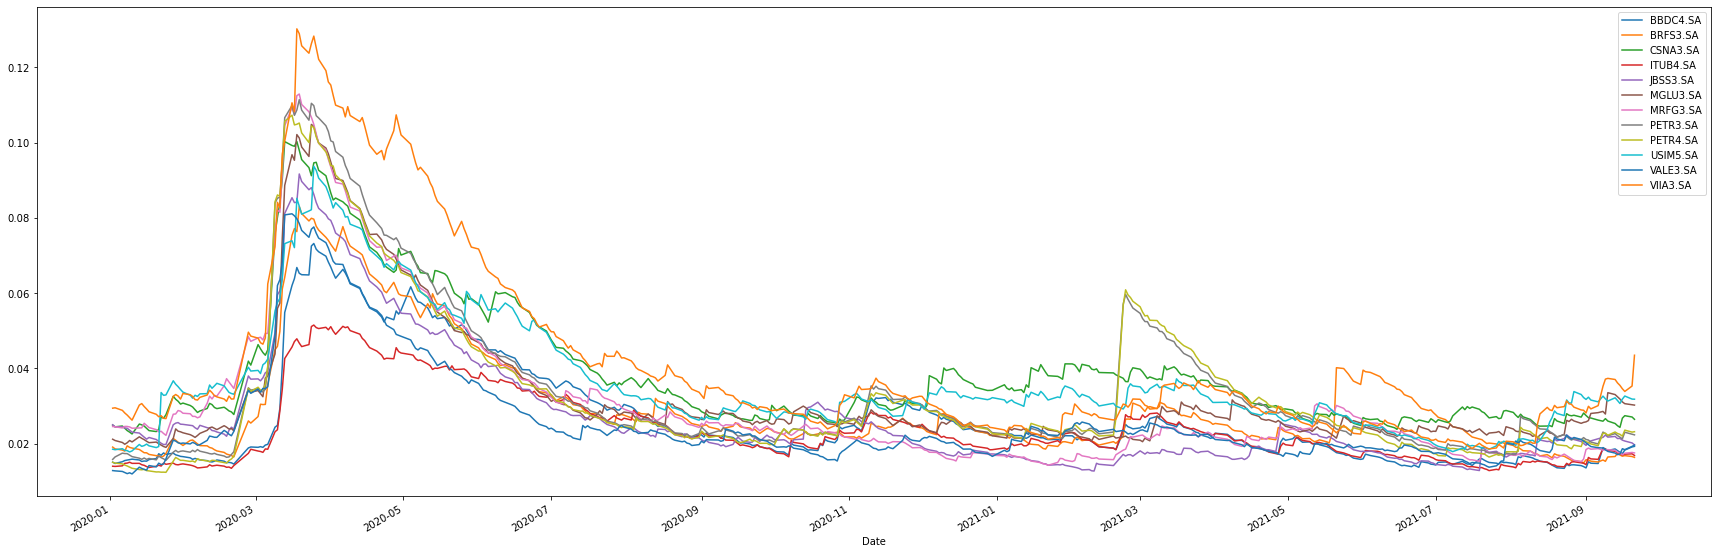

In [8]:
#Baixa os dados históricos
hist_price = yf.download(tickers=(trade_quantidade.columns+'.SA').to_list(), period="3y")['Adj Close']
retr_log = np.log(hist_price).diff()
retr_log.dropna(inplace=True)

#Calcula o peso de cada ação  - dados históricos de movimentações
weights = carteira.div(carteira['saldo'], axis=0)
weights = weights.iloc[:,:-1]
weights = weights.drop(weights.index[278])
weights.columns = retr_log.columns

#Calcula a volatilidade EWMA para todos os ativos em uma janela de 252 dias
r = retr_log.ewm(alpha = 0.05, min_periods=252, adjust=False).std(252)
vol  = (r)**(1/1)
vol['2020':].plot(figsize=(30,10))

#Baixa os dados e calcula volatilidade para o IBOVESPA
prices = yf.download(tickers= "^BVSP", period="3y", rounding=True)['Adj Close']
retr_log_ibov = np.log(prices).diff()
retr_log_ibov.dropna(inplace=True)
ibov_vol = retr_log_ibov.ewm(alpha = 0.05, min_periods=252, adjust=False).std(252)
ibov_vol  = (ibov_vol)**(1/1)

#Calculo de correlação entre os ativosb
corr = retr_log.rolling(252).corr()
new_index = pd.MultiIndex.from_tuples(corr.index, names=['Date','Ticker'])
corr_ewma = pd.DataFrame(corr, columns = corr.columns, index=new_index)

#limpa dados NA
vol.dropna( inplace=True)
vol = vol[weights.index[0]:weights.index[-1]]

In [9]:
#Calcula a volatilidade da carteira do Sr. Carlos utilizando matrizes
a=-1
n = 0
vol_cart = pd.DataFrame(columns=list(weights.columns.values), index=range(len(weights.index)))

In [10]:
len(vol.index)

395

In [11]:
corr

BBDC4.SA  BRFS3.SA  CSNA3.SA  ITUB4.SA  JBSS3.SA  \
Date                                                                    
2018-09-24 BBDC4.SA       NaN       NaN       NaN       NaN       NaN   
           BRFS3.SA       NaN       NaN       NaN       NaN       NaN   
           CSNA3.SA       NaN       NaN       NaN       NaN       NaN   
           ITUB4.SA       NaN       NaN       NaN       NaN       NaN   
           JBSS3.SA       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2021-09-21 PETR3.SA  0.636061  0.365319  0.230000  0.656757  0.241106   
           PETR4.SA  0.623912  0.384874  0.251205  0.647610  0.247653   
           USIM5.SA  0.268589  0.131110  0.754748  0.252262  0.213804   
           VALE3.SA  0.328968  0.107364  0.664447  0.298798  0.082625   
           VIIA3.SA  0.363520  0.272051  0.217514  0.340725  0.279471   

                     MGLU3.SA  MRFG3.SA  PETR3.SA  PETR4.SA  USIM5.SA  \
Date                                                                    
2018-09-24 BBDC4.SA       NaN       NaN       NaN       NaN       NaN   
           BRFS3.SA       NaN       NaN       NaN       NaN       NaN   
           CSNA3.SA       NaN       NaN       NaN       NaN       NaN   
           ITUB4.SA       NaN       NaN       NaN       NaN       NaN   
           JBSS3.SA       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2021-09-21 PETR3.SA  0.151341  0.181849  1.000000  0.977542  0.243575   
           PETR4.SA  0.182640  0.198780  0.977542  1.000000  0.275069   
           USIM5.SA  0.178639  0.208757  0.243575  0.275069  1.000000   
           VALE3.SA  0.045306  0.103498  0.328225  0.333599  0.605470   
           VIIA3.SA  0.613999  0.222989  0.385703  0.411284  0.272974   

                     VALE3.SA  VIIA3.SA  
Date                                     
2018-09-24 BBDC4.SA       NaN       NaN  
           BRFS3.SA       NaN       NaN  
           CSNA3.SA       NaN       NaN  
           ITUB4.SA       NaN       NaN  
           JBSS3.SA       NaN       NaN  
...                       ...       ...  
2021-09-21 PETR3.SA  0.328225  0.385703  
           PETR4.SA  0.333599  0.411284  
           USIM5.SA  0.605470  0.272974  
           VALE3.SA  1.000000  0.169303  
           VIIA3.SA  0.169303  1.000000  

[8808 rows x 12 columns]

## Calcula vol da carteira

In [12]:
#Calcula o corr*pesos par a par ( ex: BBDC4 x BRFS4 .... PETR4 x VALE3)
for n in range(len(vol)):
    vol_cart.loc[n] = (vol.iloc[n,]*weights.iloc[n,])*corr.loc[weights.index[n,]].dot(weights.iloc[n,]*vol.iloc[n,])
    n = n+1
    if n == (len(vol)): break

In [13]:
vol_cart = pd.DataFrame(vol_cart.sum(axis=1))
vol_cart.index = vol.index
vol_cart[0] = np.sqrt(vol_cart[0])

In [14]:
#Adiciona o IBOV para Benchmark
vol_cart['IBOV'] = ibov_vol[weights.index[0]:weights.index[-1]]

<AxesSubplot:xlabel='Date'>

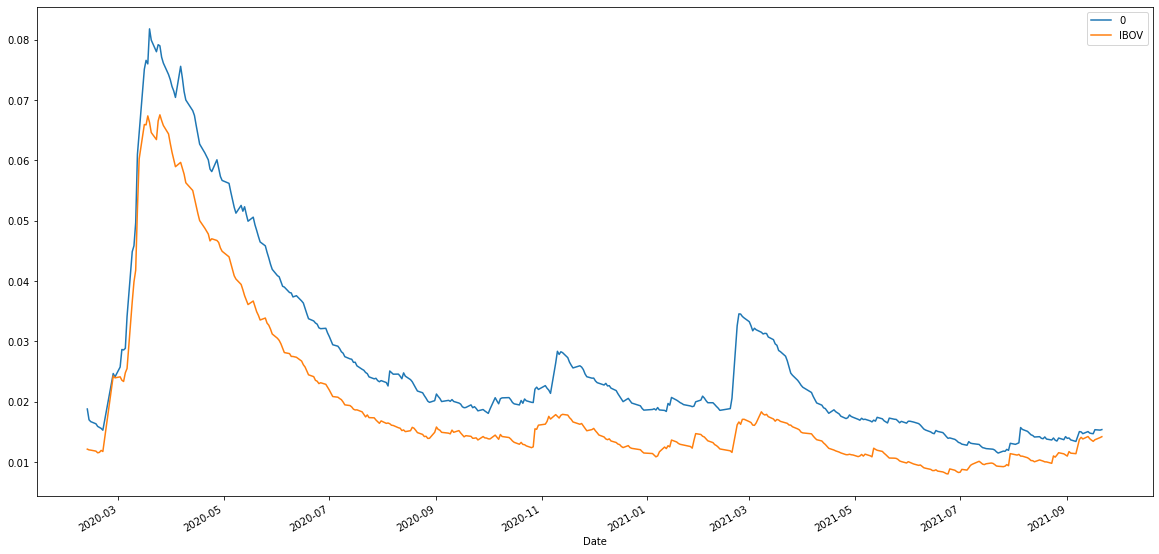

In [15]:
vol_cart.plot(figsize = (20,10))

In [16]:
vol_cart.to_excel('vol_carteira_{}-{}-{}.xlsx'.format(data_atual.day, data_atual.month,data_atual.year))